In [194]:
ColabNotebook = 'google.colab' in str(get_ipython())
import os

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '/home/santi/Documentos/Cuarto/Deep Learning/Prácticas/Fuentes/'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '/home/santi/Documentos/Cuarto/Deep Learning/Prácticas/Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [195]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn import model_selection,preprocessing

from ClassPerceptron import Perceptron

# Ajustar el tamaño predeterminado de las figuras
plt.rcParams['figure.figsize'] = [4,3]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [196]:
# Leer el archivo
datos = pd.read_csv(DATOS_DIR + "Drug5.csv")
nColum = list(datos.columns.values)
datos.head()

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY


In [197]:
#-- OPCION 1 - ordinales a numericos ---
# mapeo = {'Sex': {'F':1, 'M':0},
#           'BP':{'HIGH':2, 'NORMAL':1, 'LOW':0},
#           'Cholesterol':{'NORMAL':0, 'HIGH':1}}

# datos.replace(mapeo, inplace=True)


#-- OPCION 2 - ordinales a numericos ---
datos['Sex']         = datos['Sex'].map({'F': 1, 'M': 0}).astype(int)
datos['BP']          = datos['BP'].map({'HIGH': 2, 'NORMAL': 1, 'LOW': 0}).astype(int)
datos['Cholesterol'] = datos['Cholesterol'].map({'NORMAL': 0, 'HIGH': 1}).astype(int)

datos.describe()

,Age,Sex,BP,Cholesterol,Na,K
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,44.315000,0.480000,1.065000,0.515000,0.697095,0.050174
std,16.544315,0.500854,0.839224,0.501029,0.118907,0.017611
min,15.000000,0.000000,0.000000,0.000000,0.500169,0.020022
25%,31.000000,0.000000,0.000000,0.000000,0.583887,0.035054
50%,45.000000,0.000000,1.000000,1.000000,0.721853,0.049663
75%,58.000000,1.000000,2.000000,1.000000,0.801494,0.066000
max,74.000000,1.000000,2.000000,1.000000,0.896056,0.079788


In [198]:
#--- DATOS  ---
X = np.array(datos.iloc[:,:-1])
T = np.array((datos['Drug'] == 'drugY') * 1)        
nColum = ['Otra', 'drugY']

print(X.shape, T.shape)

(200, 6) (200,)


In [199]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split(
        X, T, test_size=0.20, random_state=42)
print(X_train.shape, T_train.shape)
print(X_test.shape, T_test.shape)

(160, 6) (160,)
(40, 6) (40,)


In [200]:
normalizarEntrada = 2   # 1 si normaliza; 0 si no; 2 si normaliza y muestra medias y desvíos; 3 si normaliza con robust scaler

if (normalizarEntrada==0):
    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
else:
    if (normalizarEntrada==1):
        #--- Normalización lineal entre 0 y 1 ---
        normalizador = preprocessing.MinMaxScaler()
    if (normalizarEntrada==3):
        #--- Normalización robusta utilizando la mediana y el rango intercuartílico
        normalizador = preprocessing.RobustScaler()
    else:
        # Normaliza utilizando la media y el desvio
        normalizador= preprocessing.StandardScaler()
    
    X_train_norm = normalizador.fit_transform(X_train)
    X_test_norm  = normalizador.transform(X_test)


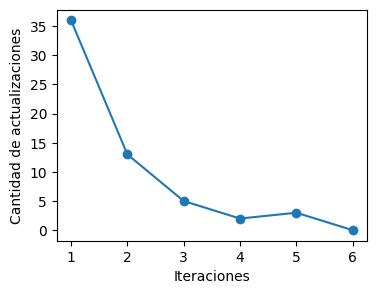

In [201]:
ppn = Perceptron(alpha=0.01, n_iter=650, random_state=None)
ppn.fit(X_train_norm, T_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Iteraciones')
plt.ylabel('Cantidad de actualizaciones')
plt.show()

In [202]:
Y_test = ppn.predict(X_test_norm)

aciertos = sum(Y_test == T_test)
print("aciertos = ", aciertos)

nAciertos = sum(Y_test == T_test)
print("%% de aciertos = %.2f %%" % (100*nAciertos/X_test_norm.shape[0]))


aciertos =  39
% de aciertos = 97.50 %


In [203]:
if (normalizarEntrada==1):
    print("Minimos: ", normalizador.data_min_)
    print("Maximos: ", normalizador.data_max_)

if (normalizarEntrada==2):
    print("Medias   :", normalizador.mean_)
    print("Desvíos  :", np.sqrt(normalizador.var_))
if (normalizarEntrada==3):
    print("Medianas :", normalizador.center_)
    print("Rangos   :", normalizador.scale_)
    
    

Medias   : [45.3875      0.48125     1.09375     0.55        0.70132351  0.05010712]
Desvíos  : [16.05108544  0.49964831  0.82003716  0.49749372  0.11576497  0.01754996]


In [204]:
from sklearn import  metrics

aciertos = metrics.accuracy_score(T_test,Y_test)
print("%% accuracy = %.3f" % aciertos)

MM = metrics.confusion_matrix(T_test,Y_test)
print("Matriz de confusión:\n%s" % MM)

report = metrics.classification_report(T_test, Y_test, zero_division=0)
print("Resultado de la clasificación:\n%s" % report)


% accuracy = 0.975
Matriz de confusión:
[[24  1]
 [ 0 15]]
Resultado de la clasificación:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.94      1.00      0.97        15

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

